In [1]:
import FinanceDataReader as fdr
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.3f}'.format

### **모델링 라이브러리 소개**

이번절에서는 Statsmodel 과 Scikit-Learn 라이브러리가 모델 개발에 어떻게 활용되는지 경험해 보는 시간입니다.

모델링을 위해 준비한 데이터를 읽습니다. 그리고 모델의 오버피팅을 최소화하기 위하여 타겟변수를 0 과 1 로 치환합니다. 예를 들어, 5% 익절의 데이터 표현은 - 'max_close' 가 5% 이상일 때 1, 아니면 0 이 됩니다. 'max_close' 가 1 인 비율을 보니, 약 24% 입니다. 10000 개 샘플을 뽑아 예측모델을 만들고 나머지로 데이터로 테스트(혹은 백테스팅)를 하겠습니다. 

In [54]:
feature_all = pd.read_pickle('feature_all.pkl') 
feature_all['target'] = np.where(feature_all['max_close']>= 1.05, 1, 0)
target = feature_all['target'].mean()
print(f'% of target:{target: 5.1%}')

% of target: 24.3%


In [55]:
mdl_all = feature_all.drop(columns=['return','max_close', 'mean_close', 'min_close', 'sector']).set_index([feature_all.index,'code'])

train = mdl_all.sample(10000, random_state=124)
test = mdl_all.loc[~mdl_all.index.isin(train.index)]

### Statsmodels - Logistic Regression   
아래 코드는 Statsmodels 라이브러리에 대한 이해가 목적입니다. Statsmodels 는 전통적인 통계모델을 구현하는데 주로 활용하는데요. 통계모델의 장점은 변수의 해석이 가능하다는 것입니다. 아래 코드는 랜덤해게 뽑은 5천개의 샘플로 모델을 만들고, 나머지 데이터로 모델 성능을 테스트하는 과정입니다. 모델 개발은 여기서부터 시작입니다.  결과를 보면 P Value(P>|z|) 가 0.01(유의수준) 보다 큰 변수가 많은데요. P Value(P>|z|) 가 유의수준보다 크다는 이야기는 coefficient 가 0 일 가능성이 높다는 말이고, Coefficient 가 0 이라는 말은 예측에 도움을 안 준다는 말입니다. 이런 변수들은 적절한 변형을 통하여 유의미하게 만들거나 제거해야 합니다. 가장 대표적인 방법이 Binning 입니다. 이 절은 라이브러리를 소개하는 것이 목적이라, 모델 완성을 위한 나머지 과정은 생략하도록 하겠습니다. 제가 통계모델의 장점으로 해석을 언급했는데요. 아직 모델이 완성되지 않았지만, 변수 'volume_z' 를 해석해 보도록 하겠습니다. 'volume_z' 는 과거 20일대비 당일 거래량이 얼마나 많은 지를 의미하는 변수입니다. 'volume_z' 가 1 증가하면 log(odds) 는 그 변수의 계수 0.1765 만큼 증가하게 됩니다. 즉, odds 는 exp(0.1765) 증가하게 됩니다. 풀어서 이야기하면, 전일 20일 대비 당일 거래량 표준화 값 z 가  1 증가할 때마다, 5% 로 익절할 odds(=p/1-p)는 exp(0.1765) 증가한다고 말할 수 있습니다. 

모델을 완성하기까지 필요한 나머지 절차는 아래와 같습니다.
1. 각 설명변수와 타겟변수와 관계를 분석합니다 (변수가 상호작용 여부 체크)
2. 선형적인 관계가 없는 변수는 binning 등을 통해 문제를 해결합니다.
3. 다중 공선성이 의심되는 변수는 제거하거나 새로운 변수로 대체합니다. (다중 공선성이 높은 모델은 변수의 해석이 부정확함)
4. 테스트 데이터셋과 예측성능을 비교합니다 (오버피팅 여부 확인). 
5. 변수를 해석하고 예측값을 만듭니다.

In [56]:
import statsmodels.api as sm

X = train.drop(columns=['target'])
y = train['target']

X = sm.add_constant(X)
model = sm.Logit(y, X)
results = model.fit()
print(results.summary())
yhat = results.predict(X)
yhat = pd.Series(yhat, name='yhat')

X_test = test.drop(columns=['target'])
y_test = test['target']
X_test = sm.add_constant(X_test)
yhat_test = results.predict(X_test)
yhat_test = pd.Series(yhat_test, name='yhat')

Optimization terminated successfully.
         Current function value: 0.553318
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9991
Method:                           MLE   Df Model:                            8
Date:                Thu, 09 Jun 2022   Pseudo R-squ.:                0.009004
Time:                        09:54:50   Log-Likelihood:                -5533.2
converged:                       True   LL-Null:                       -5583.5
Covariance Type:            nonrobust   LLR p-value:                 3.295e-18
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -13.9964      6.882     -2.034      0.042     -27.485      -0.508
price

<br> 개발 데이터가 아니라, 테스트데이터에서도 좋은 성능을 보이는지 확인해봅니다. 쉽게 확인하는 방법은 Decile 분석입니다. 예측값의 변별력을 알기 위해서 정렬된 예측값을 10 개 구간으로 나누고, 각 구간에서 'target'의 평균값을 찍어봅니다. 모델이 예측력이 좋다면, 예측값의 십분위 수가 증가하면 5%로 익절할 확률도 같이 증가하는 형태를 보이게 됩니다. 아래 결과에서 완성되지 않은 모델이지만 단조증가하는 좋은 흐름을 보여주고 있습니다. 테스트 결과에서 제 1 십분위수(첫 번째 구간) 에서 종목을 선택한다면 19.7% 로 익절할 확률이 있지만, 제 10 분위수(마지막 구간)에서 종목을 선택한다면 34.9% 로 익절할 확률이 생깁니다. 

                count  mean
yhat                       
(0.157, 0.202]   1000 0.197
(0.202, 0.213]   1000 0.217
(0.213, 0.222]   1000 0.217
(0.222, 0.23]    1000 0.216
(0.23, 0.238]    1000 0.210
(0.238, 0.247]   1000 0.245
(0.247, 0.257]   1000 0.235
(0.257, 0.272]   1000 0.284
(0.272, 0.298]   1000 0.291
(0.298, 0.653]   1000 0.352
                count  mean
yhat                       
(0.126, 0.202]  32019 0.185
(0.202, 0.213]  32019 0.200
(0.213, 0.222]  32018 0.207
(0.222, 0.23]   32019 0.218
(0.23, 0.238]   32018 0.226
(0.238, 0.247]  32019 0.238
(0.247, 0.258]  32018 0.246
(0.258, 0.272]  32019 0.264
(0.272, 0.298]  32018 0.299
(0.298, 0.778]  32019 0.343


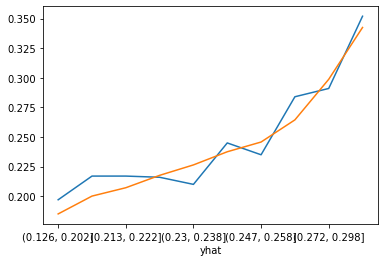

In [57]:
def perf(y, yhat): # Decile 분석 함수
    combined = pd.concat([y, yhat], axis=1)
    ranks = pd.qcut(combined['yhat'], q=10)
    print(combined.groupby(ranks)['target'].agg(['count','mean']))
    combined.groupby(ranks)['target'].mean().plot()

perf(y, yhat)
perf(y_test, yhat_test)

### SK-Learn - Logistic Regression
Scikit-Learn 에서도 Logistic Regression 을 지원합니다. 하지만 계수를 추정하는 방식이 Statsmodels 과는 다른데요. Scikit-Learn Logistic Regression 은 loss 함수를 만들고, 과대적합을 해결하기 위해 penalty term (L1/L2) 도 추가합니다. 이런 방식으로 Penalty Term 이 있는 Loss 함수를 최소화하는 방식을 계수를 찾을 때는 입력 피처의 스케일이 동일해야 의미가 있습니다. 아래 코드에서 입력 피쳐를 Scaling 하는 부분이 반드시 들어가야 합니다. 아래 Test 데이터의 결과가 Train 데이터보다 모델성능이 많이 떨어지는 데요. 즉 overfitting(과대적합)된 상황입니다.

SK-Learn 으로 만드는 모델은 절차가 아래와 같습니다.
1. 입력 피처 스케일링 (Loss 함수 + Penalty Term 로 훈련하는 모델만 해당)
2. 하이퍼파라미터 튜닝 (성능을 최고로 만드는 하이퍼파라미터을 찾기)
3. 테스트 데이터셋과 예측성능을 비교합니다 (오버피팅 여부 확인) 
4. 변수의 중요도 파악과 이해
5. 예측값 만들기

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

X = train.drop(columns=['target'])
y = train['target']

X_test = test.drop(columns=['target'])
y_test = test['target']

# 입력 피처 표준화
scaler = StandardScaler() # 평균이 0 이고 편차가 1 가 되도록 피처 표준화
scaler.fit_transform(X)
scaler.transform(X_test)

lr = LogisticRegression(fit_intercept=True, C=1) # 정해진 하이퍼파라미터를 가진 객체를 생성
lr.fit(X, y)
print(lr.coef_)
yhat = lr.predict_proba(X)[:,1]
yhat_test = lr.predict_proba(X_test)[:,1]

yhat = pd.Series(yhat, name='yhat', index=y.index) 
yhat_test = pd.Series(yhat_test, name='yhat', index=y_test.index) 

[[-0.0688501   0.14416558  0.13212602  0.30913545  0.03966044  0.02995417
   0.30028913 -1.09230966]]


                count  mean
yhat                       
(0.159, 0.204]   1000 0.182
(0.204, 0.214]   1000 0.215
(0.214, 0.223]   1000 0.251
(0.223, 0.23]    1000 0.195
(0.23, 0.239]    1000 0.245
(0.239, 0.247]   1000 0.238
(0.247, 0.257]   1000 0.228
(0.257, 0.271]   1000 0.274
(0.271, 0.296]   1000 0.284
(0.296, 0.58]    1000 0.352
                count  mean
yhat                       
(0.144, 0.203]  32019 0.178
(0.203, 0.214]  32019 0.202
(0.214, 0.223]  32018 0.213
(0.223, 0.231]  32019 0.222
(0.231, 0.239]  32018 0.227
(0.239, 0.247]  32019 0.239
(0.247, 0.258]  32018 0.252
(0.258, 0.272]  32019 0.263
(0.272, 0.296]  32018 0.293
(0.296, 0.688]  32019 0.337


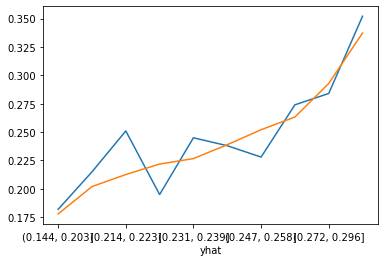

In [59]:
perf(y, yhat)
perf(y_test, yhat_test)
plt.show()

### SK-learn - Random Forerst  
Random Forest 는 Scikit-Learn 에서 인기있는 모델인데요. Decision-Tree(의사결정나무)의 문제점을 보완하고자 나온 개념입니다. 모델을 훈련시키기 위한 loss 함수와 Penalty term 이 없기 때문에 피쳐 스케일링이 불필요해서 쉽게 모델을 만들어 볼 수 있습니다.
sklearn 의 ensemble(앙상블) 모델군에서 RandomForestClassifier 을 불러옵니다. 그 다음 정해진 하이퍼파라미터(hyperparameter)를 가진 객체를 하나 생성합니다. 여기서 어떤 하이퍼파라미터로 객체를 생성하는가에 따라 모델의 성능이 결정되므로, 하이퍼파라미터 튜닝이라 절차가 필요합니다. 보통 최적의 하이퍼파라미터는 Grid Search 로 찾습니다. 그리고 fit 를 이용해서 데이터를 적용하면 됩니다. 예측값 생성은 predict 함수나 predict_proba 함수로 할 수 있는데요. predict 함수는 0/1 값을 리턴하고, predict_proba 함수는 '0 일 확률'/'1 일 확률'을 리턴합니다. 각 피처의 중요도를 그래프로 파악해보겠습니다.

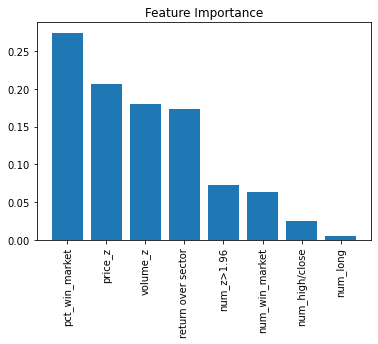

In [60]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=4, min_samples_leaf=30) # 정해진 하이퍼파라미터를 가진 객체를 생성

X = train.drop(columns=['target'])
y = train['target']
rf.fit(X, y)
yhat = rf.predict_proba(X)[:,1] # 첫번째 열은 0일 확률, 두번째 열은 1 일 확률 -> 1 일 확률을 저장
yhat = pd.Series(yhat, name='yhat', index=y.index) 

X_test = test.drop(columns=['target'])
y_test = test['target']
yhat_test = rf.predict_proba(X_test)[:,1] # 첫번째 열은 0일 확률, 두번째 열은 1 일 확률 -> 1 일 확률을 저장
yhat_test = pd.Series(yhat_test, name='yhat', index=y_test.index) 

importances = rf.feature_importances_
sorted_indices = np.argsort(importances)[::-1]

import matplotlib.pyplot as plt
 
plt.title('Feature Importance')
plt.bar(range(X.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[sorted_indices], rotation=90)
plt.show()


                count  mean
yhat                       
(0.176, 0.204]   1000 0.124
(0.204, 0.212]   1000 0.174
(0.212, 0.219]   1000 0.183
(0.219, 0.229]   1002 0.200
(0.229, 0.236]    998 0.217
(0.236, 0.243]   1000 0.229
(0.243, 0.255]   1000 0.296
(0.255, 0.276]   1000 0.279
(0.276, 0.308]   1000 0.323
(0.308, 0.46]    1000 0.439
                count  mean
yhat                       
(0.167, 0.204]  32019 0.151
(0.204, 0.212]  32019 0.180
(0.212, 0.219]  32018 0.195
(0.219, 0.228]  32025 0.207
(0.228, 0.235]  32012 0.220
(0.235, 0.243]  32019 0.234
(0.243, 0.256]  32018 0.265
(0.256, 0.276]  32019 0.291
(0.276, 0.31]   32018 0.317
(0.31, 0.471]   32019 0.367


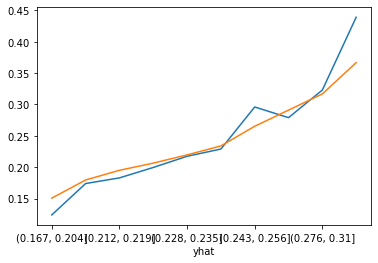

In [61]:
perf(y, yhat)
perf(y_test, yhat_test)
plt.show()